In [604]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

#import xlrd
import openpyxl
import pickle

# import torch

from joblib import dump,load
from sklearn import utils,preprocessing
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,LassoCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from tensorflow.keras import models
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import datetime
import time

# Model label

In [628]:
global label
# label="PRI"
# label="FUC"
# label="RFE"
label="GP"

# Initial parameter setting

In [606]:
global N
global n
global test_size     # 回归运行轮次和测试集大小
N=100    # runing time for prediction
n=10    # runing time for 10K-CV
test_size=0.20    # the ratio of testing set

# read data

In [607]:
# data = pd.read_excel('list-PRI.xlsx',header=0)    # Primary features
# data = pd.read_excel('list-FUC.xlsx',header=0)    # Primary features using statistical functions
# data = pd.read_excel('list-RFE.xlsx',header=0)    # Primary features using RFE
data = pd.read_excel('list-GP.xlsx',header=0)    # Primary features using Gplearn
data = data.iloc[:,1:]
data

,GH,1_Z,1_Eg,1_Ip1,1_Ip2,1_Ea,1_Homo,1_Lumo,1_Ros,1_Rop,...,Std0W_Boi,Std1W_Boi,Aver_de,AverW_de,Max_de,Min_de,Std0_de,Std1_de,Std0W_de,Std1W_de
0,0.477963,41,1.60,652.1,1380.0,-0.8556,-4.6186,-0.7269,1.5752,1.7332,...,1908.944814,2337.970370,6.540000,6.017714,8.570,5.323000,1.444871,1.769599,1.536371,1.881662
1,1.358324,24,1.66,652.9,1590.6,-0.7587,-4.4654,0.4900,1.4266,1.4063,...,1974.945569,2418.804457,3.604333,2.583143,7.190,1.800000,2.535467,3.105300,2.733390,3.347705
2,0.696354,72,1.30,658.5,1440.0,0.7772,-2.6937,-0.4781,1.5366,1.7316,...,1879.519085,2301.931360,7.122000,5.839429,13.310,2.329000,4.590215,5.621842,4.766032,5.837173
3,0.567620,25,1.55,717.3,1509.0,-1.0190,-4.4043,1.8306,1.3699,1.2646,...,917.204031,1123.340933,6.767333,6.406857,7.365,5.727000,0.738343,0.904282,0.821641,1.006301
4,1.239236,42,2.16,684.3,1560.0,-1.5561,-4.3183,-0.1345,1.5418,1.6626,...,2346.911351,2874.367641,4.634333,3.024571,10.280,1.800000,3.992100,4.889304,4.304439,5.271840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.797232,23,1.63,650.9,1414.0,-0.2221,-4.4742,0.1316,1.5000,1.4672,...,1747.923805,2140.760716,4.455417,2.962143,7.365,0.001251,3.198489,3.917334,3.529901,4.323228
146,-0.918804,77,2.20,880.0,1600.0,-2.5410,-5.6901,0.5069,0.9966,1.4695,...,1980.111379,2425.131256,8.904000,4.930000,22.560,1.823000,9.658460,11.829149,10.444066,12.791316
147,-3.566696,39,1.22,600.0,1180.0,0.6624,-2.5187,-0.9887,1.7851,1.9482,...,1330.313116,1629.294166,4.553333,3.784857,7.365,1.823000,2.263243,2.771895,2.390151,2.927326
148,-0.190484,40,1.33,640.1,1270.0,-0.0117,-3.6022,-0.5279,1.6694,1.7575,...,2133.390882,2612.859541,4.628750,3.036429,7.365,0.001251,3.290270,4.029742,3.655320,4.476835


In [608]:
x_data = np.array(data.iloc[:,1:])    # features
y_data = np.array(data.iloc[:,0])    # ΔGH

# The number of Sample

In [609]:
global size
size = x_data.shape[1]

# Defined function

In [610]:
## gerante ANNs model
def anns_model(optimizer):
    # create model
    model = Sequential()
    model.add(Dense(units=int(size), input_dim=int(size), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='linear',kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [611]:
##  Model regression
def fitRegression(inputData,outputData,test_size,N,regr):
    r2_train = []    # training R2
    r2_test = []    # testing R2
    rmse_train = []    # training rmse
    rmse_test = []    # testing rmse
    best_r2 = []
    best_rmse = []
    for i in range(N):
        print('---------round: %d---------'%(i+1))
        X_train,X_test,y_train,y_test = train_test_split(inputData,outputData,test_size=test_size,random_state=None)    # Randomly split data                                                                                                                # 该方法对dataframe也适用
        score_train = r2_score(y_train,regr.predict(X_train))
        error_train = np.sqrt(sum((y_train-regr.predict(X_train))**2)/max(y_train.shape))   
        r2_train.append(score_train)   
        rmse_train.append(error_train)
        print('r2_train:   %.3f'%score_train)
        print('RMSE_train: %.3f'%error_train)
        
        score_test = r2_score(y_test,regr.predict(X_test))
        error_test = np.sqrt(sum((y_test-regr.predict(X_test))**2)/max(y_test.shape))
        mae_test = sum(abs(y_test - regr.predict(X_test))/max(y_test.shape))
        r2_test.append(score_test)   
        rmse_test.append(error_test)
        print('r2_test:   %.3f'%score_test)
        print('RMSE_test: %.3f'%error_test)
        if i == 0:
            max_score = score_test           #  At run 0, record R2 and the model at this point
            worst_mae = mae_test
            y_train_best = y_train
            y_test_best = y_test
            y_train_predict_best = regr.predict(X_train)
            y_test_predict_best = regr.predict(X_test)
            best_r2 = score_test
            best_rmse = error_test
        if i>0:
            if score_test>max_score:
                max_score = score_test       #  Update the maximum R2 value and save the model and the data
                y_train_best = y_train
                y_test_best = y_test
                y_train_predict_best = regr.predict(X_train)
                y_test_predict_best = regr.predict(X_test)
                best_r2 = score_test
                best_rmse = error_test
            if mae_test>worst_mae:
                worst_mae = mae_test
        print('--------------------------') 
    return r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,worst_mae

In [612]:
##  Hyperparameter optimization
def optHyperparameter(inputData,outputData,test_size,n,search):
    r2 = []
    for i in range(n):
        X_train,X_test,y_train,y_test = train_test_split(inputData,outputData,test_size=test_size,random_state=None)    
        search.fit(X_train,y_train)
        regr = search.best_estimator_
        r2 = r2_score(y_train,regr.predict(X_train))
        if i == 0:
            max_score = r2          
            best_regr = regr    
        if i>0:
            if r2>max_score:
                max_score = r2       
                best_regr = regr  
    return max_score,best_regr

In [613]:
##  GridCv generation
def generateSearch(model,method,param_grid,n_jobs,cv):    
    if model=='svr':
        svr = SVR()
        if method=='grid_search':
            search = GridSearchCV(svr,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(svr,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search     
    elif model=='krr':
        krr = KernelRidge()
        if method=='grid_search':
            search = GridSearchCV(krr,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(krr,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
    elif model=='rfr':
        rfr = RandomForestRegressor()
        if method=='grid_search':
            search = GridSearchCV(rfr,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(rfr,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
    elif model=='xgbr':
        xgbr = XGBRegressor()
        if method=='grid_search':
            search = GridSearchCV(xgbr,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(xgbr,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
    elif model=='lasso':
        lasso = Lasso()
        if method=='grid_search':
            search = GridSearchCV(lasso,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(lasso,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
    elif model=='anns':
        anns = KerasRegressor(anns_model)
        if method=='grid_search':
            search = GridSearchCV(estimator = anns,param_grid=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search
        elif method=='randomized_search':
            search = RandomizedSearchCV(estimator = anns,param_distributions=param_grid,n_jobs=n_jobs,cv=cv,scoring = 'r2')
            return search

In [614]:
##  Draw bar
def plotBar(r2_train,rmse_train,r2_test,rmse_test,N,model,label,saving):
    mpl.rcParams['font.sans-serif']=['SimHei'] 
    mpl.rcParams['axes.unicode_minus']=False 
    plt.figure(figsize=(6,6))
    rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
    mean_rmse_r2 = np.mean(rmse_r2,1) #average
    std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) # error bar
    error_attri = dict(elinewidth=2, ecolor="black",capsize=3)
    x = np.arange(len(rmse_r2))
    rects = plt.bar(x,mean_rmse_r2,color="c",width=0.6,align="center",
            yerr=std_err,error_kw=error_attri,
            tick_label=["Training rmse","Testing rmse","Training R2","Testing R2"])
    plt.tick_params(labelsize=8)
    for x,mean_rmse_r2,std_err in zip(x,mean_rmse_r2,std_err):
        text_str = '%.3f'%mean_rmse_r2+"±"+'%.3f'%std_err
        plt.text(x,mean_rmse_r2+std_err*1.1,text_str,ha='center',va='bottom',fontsize=10)
    plt.ylim([0,1.2])
    plt.title("Random "+str(N)+" times"+model+"prediction",fontsize=10)
    if saving == 'saving':
        plt.savefig(model+'_plotbar_'+label+'.png')
    plt.show()

In [615]:
##  Draw scatter
def plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,model,label,saving):
    mpl.rcParams['font.sans-serif']=['SimHei']
    mpl.rcParams['axes.unicode_minus']=False 
    R2_train = r2_score(y_train_best,y_train_predict_best)
    rmse_train = np.sqrt(sum((y_train_best-y_train_predict_best)**2)/max(y_train_best.shape))
    plt.figure(figsize=(6,6))
    plt.scatter(y_train_predict_best,y_train_best,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=50,
            alpha=0.9,
            label='Training Data')
    plt.scatter(y_test_predict_best,y_test_best,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=50,
            alpha=0.9,
            label='Test Data')
# plt.plot(line_x,line_y,linestyle='--',color='black',alpha=0.7)
    plt.xlabel("Predicted Delta_G",fontsize=10)
    plt.ylabel("Actual Delta_G",fontsize=10)
    plt.tick_params(labelsize=10)
    plt.legend(loc='upper left',fontsize=10)
    plt.title(model+'Training RMSE:%.2f,R2:%.2f Testing RMSE:%.2f,R2:%.2f'%(rmse_train,R2_train,best_rmse,best_r2),fontsize=10)
    if saving == 'saving':
        plt.savefig(model+'_plotscatter'+label+'.png')
    plt.show()
    Y_predict = np.concatenate((y_train_predict_best,y_test_predict_best),axis=0)
    Y_act = np.concatenate((y_train_best,y_test_best),axis=0)
    pd.DataFrame(Y_predict).to_csv('A.csv',sep=',')
    pd.DataFrame(Y_act).to_csv('B.csv',sep=',')
    Y_total = pd.DataFrame(np.array([Y_predict, Y_act]).T)
    Y_total.columns = ["Predicted GH", "Actual GH"]
    Y_total.to_csv("Best\\"+model+'_best_prediction_'+label+'.csv',sep=',')

# The beginning of time

In [416]:
start_time = datetime.datetime.now()
time.sleep(5)
print(start_time)

2021-05-17 19:08:54.632472


# SVR

In [300]:
def generateSvrParamGrid(kernel,low1,high1,num1,base1,degree,gamma,low2,high2,num2,base2,epsilon):      # 
    if isinstance(gamma,int) or isinstance(gamma,float):
        param_grid = {
            'kernel':kernel,
            'C':np.logspace(low1,high1,num1,base=base1),
            'degree':degree,
            'gamma':np.logspace(low2,high2,num2,base=base2),
            'epsilon':epsilon
        }
        return param_grid
    elif isinstance(gamma,list):
        param_grid = {
            'kernel':kernel,
            'C':np.logspace(low1,high1,num1,base=base1),
            'degree':degree,
            'gamma':gamma,
            'epsilon':epsilon
        }
        return param_grid

In [301]:
param = generateSvrParamGrid(['linear','poly','rbf'],-3,3,20,2,[3],['scale'],0,0,0,0,[0.001])
param

{'kernel': ['linear', 'poly', 'rbf'],
 'C': array([0.125     , 0.15558657, 0.19365746, 0.241044  , 0.30002568,
        0.37343974, 0.46481768, 0.57855512, 0.72012327, 0.8963321 ,
        1.11565792, 1.38865114, 1.72844379, 2.15138117, 2.6778082 ,
        3.33304803, 4.14862018, 5.16375679, 6.42728981, 8.        ]),
 'degree': [3],
 'gamma': ['scale'],
 'epsilon': [0.001]}

In [16]:
search = generateSearch('svr','grid_search',param,-1,10)
search

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([0.125     , 0.15558657, 0.19365746, 0.241044  , 0.30002568,
       0.37343974, 0.46481768, 0.57855512, 0.72012327, 0.8963321 ,
       1.11565792, 1.38865114, 1.72844379, 2.15138117, 2.6778082 ,
       3.33304803, 4.14862018, 5.16375679, 6.42728981, 8.        ]),
                         'degree': [3], 'epsilon': [0.001], 'gamma': ['scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2')

In [17]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)

In [18]:
max_score

0.4688768185328157

In [19]:
best_regr

SVR(C=8.0, epsilon=0.001)

In [432]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,svr_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.876
RMSE_train: 0.373
r2_test:   0.668
RMSE_test: 0.419
--------------------------
---------round: 2---------
r2_train:   0.839
RMSE_train: 0.394
r2_test:   0.905
RMSE_test: 0.334
--------------------------
---------round: 3---------
r2_train:   0.830
RMSE_train: 0.409
r2_test:   0.940
RMSE_test: 0.248
--------------------------
---------round: 4---------
r2_train:   0.859
RMSE_train: 0.379
r2_test:   0.832
RMSE_test: 0.397
--------------------------
---------round: 5---------
r2_train:   0.865
RMSE_train: 0.386
r2_test:   0.750
RMSE_test: 0.368
--------------------------
---------round: 6---------
r2_train:   0.849
RMSE_train: 0.387
r2_test:   0.870
RMSE_test: 0.362
--------------------------
---------round: 7---------
r2_train:   0.870
RMSE_train: 0.348
r2_test:   0.797
RMSE_test: 0.496
--------------------------
---------round: 8---------
r2_train:   0.870
RMSE_train: 0.372
r2_test:   0.741
RMSE_test: 0.421
--------------------------
--------

r2_test:   0.868
RMSE_test: 0.316
--------------------------
---------round: 79---------
r2_train:   0.848
RMSE_train: 0.378
r2_test:   0.871
RMSE_test: 0.400
--------------------------
---------round: 80---------
r2_train:   0.858
RMSE_train: 0.393
r2_test:   0.821
RMSE_test: 0.338
--------------------------
---------round: 81---------
r2_train:   0.847
RMSE_train: 0.401
r2_test:   0.882
RMSE_test: 0.296
--------------------------
---------round: 82---------
r2_train:   0.884
RMSE_train: 0.335
r2_test:   0.744
RMSE_test: 0.531
--------------------------
---------round: 83---------
r2_train:   0.848
RMSE_train: 0.401
r2_test:   0.887
RMSE_test: 0.299
--------------------------
---------round: 84---------
r2_train:   0.839
RMSE_train: 0.373
r2_test:   0.883
RMSE_test: 0.418
--------------------------
---------round: 85---------
r2_train:   0.871
RMSE_train: 0.372
r2_test:   0.757
RMSE_test: 0.421
--------------------------
---------round: 86---------
r2_train:   0.834
RMSE_train: 0.374


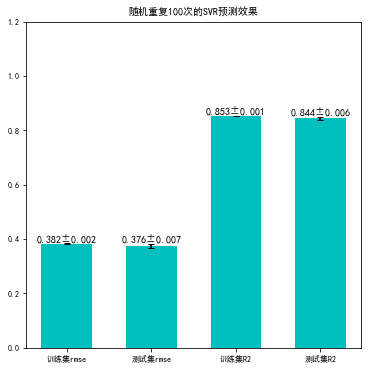

In [433]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'SVR',label,'saving')

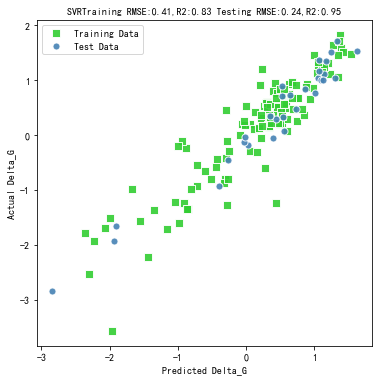

In [434]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'SVR',label,'saving')

In [23]:
best_svr = best_regr

In [24]:
dump(best_svr, "Models\\svr_"+label+".joblib")    # Save to hard disk

['D:\\Code\\师妹\\zjnpaper_II\\图5\\Models\\svr_20210516_1750.joblib']

In [435]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
svr_predicted_result = [mean_rmse_r2,std_err]
svr_predicted_result = pd.DataFrame(svr_predicted_result)
svr_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
svr_predicted_result.index = ["Mean", "std"]
svr_predicted_result.to_csv("Excels\\"+"SVR_"+label+".csv",sep=',')

In [26]:
end_time_svr = datetime.datetime.now()
delta_svr = end_time_svr - start_time
print(end_time_svr)
print(delta_svr)

2021-05-17 02:28:09.022761
8:37:07.176889


# KRR

In [436]:
def generateKrrParamGrid(low1,high1,num1,base1,kernel,low2,high2,num2):      # 
    param_grid = {
        'alpha':np.logspace(low1,high1,num1,base=base1),
        'kernel':kernel,
        'degree':np.arange(low2,high2,num2)
    }
    return param_grid

In [437]:
param = generateKrrParamGrid(-6,6,13,10,['linear','poly','rbf'],1,7,0.5)
param

{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'kernel': ['linear', 'poly', 'rbf'],
 'degree': array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5])}

In [438]:
search = generateSearch('krr','grid_search',param,-1,10)
search

GridSearchCV(cv=10, estimator=KernelRidge(), n_jobs=-1,
             param_grid={'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         'degree': array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5]),
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='r2')

In [439]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)

In [440]:
max_score

0.8717641029039629

In [441]:
best_regr

KernelRidge(alpha=1.0, degree=1.0, kernel='poly')

In [442]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,krr_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.853
RMSE_train: 0.373
r2_test:   0.887
RMSE_test: 0.369
--------------------------
---------round: 2---------
r2_train:   0.859
RMSE_train: 0.383
r2_test:   0.876
RMSE_test: 0.326
--------------------------
---------round: 3---------
r2_train:   0.863
RMSE_train: 0.372
r2_test:   0.843
RMSE_test: 0.373
--------------------------
---------round: 4---------
r2_train:   0.868
RMSE_train: 0.380
r2_test:   0.819
RMSE_test: 0.339
--------------------------
---------round: 5---------
r2_train:   0.853
RMSE_train: 0.365
r2_test:   0.878
RMSE_test: 0.401
--------------------------
---------round: 6---------
r2_train:   0.861
RMSE_train: 0.382
r2_test:   0.864
RMSE_test: 0.332
--------------------------
---------round: 7---------
r2_train:   0.864
RMSE_train: 0.380
r2_test:   0.842
RMSE_test: 0.340
--------------------------
---------round: 8---------
r2_train:   0.834
RMSE_train: 0.364
r2_test:   0.901
RMSE_test: 0.405
--------------------------
--------

r2_train:   0.868
RMSE_train: 0.381
r2_test:   0.811
RMSE_test: 0.335
--------------------------
---------round: 80---------
r2_train:   0.837
RMSE_train: 0.367
r2_test:   0.909
RMSE_test: 0.395
--------------------------
---------round: 81---------
r2_train:   0.857
RMSE_train: 0.367
r2_test:   0.874
RMSE_test: 0.392
--------------------------
---------round: 82---------
r2_train:   0.824
RMSE_train: 0.392
r2_test:   0.946
RMSE_test: 0.283
--------------------------
---------round: 83---------
r2_train:   0.856
RMSE_train: 0.377
r2_test:   0.882
RMSE_test: 0.353
--------------------------
---------round: 84---------
r2_train:   0.852
RMSE_train: 0.385
r2_test:   0.899
RMSE_test: 0.319
--------------------------
---------round: 85---------
r2_train:   0.854
RMSE_train: 0.377
r2_test:   0.888
RMSE_test: 0.354
--------------------------
---------round: 86---------
r2_train:   0.862
RMSE_train: 0.388
r2_test:   0.856
RMSE_test: 0.305
--------------------------
---------round: 87---------


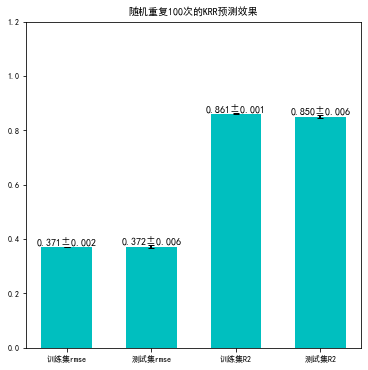

In [443]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'KRR',label,'saving')

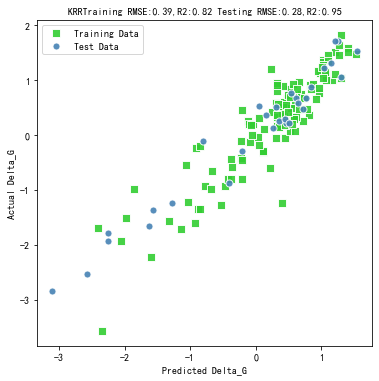

In [444]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'KRR',label,'saving')

In [445]:
best_krr = best_regr

In [446]:
dump(best_krr, "Models\\krr_"+label+".joblib")    # 存储至硬盘

['D:\\Code\\师妹\\zjnpaper_II\\图5\\Models\\krr_20210517_1910.joblib']

In [447]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
krr_predicted_result = [mean_rmse_r2,std_err]
krr_predicted_result = pd.DataFrame(krr_predicted_result)
krr_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
krr_predicted_result.index = ["Mean", "std"]
krr_predicted_result.to_csv("Excels\\"+"KRR_"+label+".csv",sep=',')

In [231]:
end_time_krr = datetime.datetime.now()
delta_krr = end_time_krr - end_time_svr
print(end_time_krr)
print(delta_krr)

2021-05-17 16:29:36.842748
14:01:27.819987


# RFR

In [40]:
def generateRfrParamGrid(low1,high1,num1,low2,high2,num2):      # 
    param_grid = {
        'n_estimators':np.arange(int(low1),int(high1),int(num1)),
        'max_depth':np.arange(int(low2),int(high2),int(num2))
    }
    return param_grid

In [41]:
# param = generateRfrParamGrid(100,1000,10,1,max(math.floor(x_data.shape[1]/3),1),1)
param = generateRfrParamGrid(300,500,10,3,7,1)
param 

{'n_estimators': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
        430, 440, 450, 460, 470, 480, 490]),
 'max_depth': array([3, 4, 5, 6])}

In [42]:
search = generateSearch('rfr','grid_search',param,-1,10)
search

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([3, 4, 5, 6]),
                         'n_estimators': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440, 450, 460, 470, 480, 490])},
             scoring='r2')

In [43]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)

In [44]:
max_score

0.9480450181219614

In [130]:
best_regr

RandomForestRegressor(max_depth=6, n_estimators=450)

In [449]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,rfr_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.925
RMSE_train: 0.272
r2_test:   0.916
RMSE_test: 0.300
--------------------------
---------round: 2---------
r2_train:   0.908
RMSE_train: 0.294
r2_test:   0.967
RMSE_test: 0.201
--------------------------
---------round: 3---------
r2_train:   0.917
RMSE_train: 0.291
r2_test:   0.950
RMSE_test: 0.216
--------------------------
---------round: 4---------
r2_train:   0.922
RMSE_train: 0.291
r2_test:   0.925
RMSE_test: 0.218
--------------------------
---------round: 5---------
r2_train:   0.918
RMSE_train: 0.283
r2_test:   0.942
RMSE_test: 0.256
--------------------------
---------round: 6---------
r2_train:   0.933
RMSE_train: 0.259
r2_test:   0.878
RMSE_test: 0.343
--------------------------
---------round: 7---------
r2_train:   0.929
RMSE_train: 0.254
r2_test:   0.906
RMSE_test: 0.356
--------------------------
---------round: 8---------
r2_train:   0.929
RMSE_train: 0.281
r2_test:   0.881
RMSE_test: 0.264
--------------------------
--------

r2_test:   0.844
RMSE_test: 0.272
--------------------------
---------round: 68---------
r2_train:   0.920
RMSE_train: 0.290
r2_test:   0.937
RMSE_test: 0.220
--------------------------
---------round: 69---------
r2_train:   0.913
RMSE_train: 0.296
r2_test:   0.964
RMSE_test: 0.187
--------------------------
---------round: 70---------
r2_train:   0.923
RMSE_train: 0.255
r2_test:   0.919
RMSE_test: 0.354
--------------------------
---------round: 71---------
r2_train:   0.936
RMSE_train: 0.249
r2_test:   0.877
RMSE_test: 0.371
--------------------------
---------round: 72---------
r2_train:   0.923
RMSE_train: 0.283
r2_test:   0.918
RMSE_test: 0.257
--------------------------
---------round: 73---------
r2_train:   0.930
RMSE_train: 0.276
r2_test:   0.866
RMSE_test: 0.285
--------------------------
---------round: 74---------
r2_train:   0.916
RMSE_train: 0.294
r2_test:   0.955
RMSE_test: 0.197
--------------------------
---------round: 75---------
r2_train:   0.914
RMSE_train: 0.291


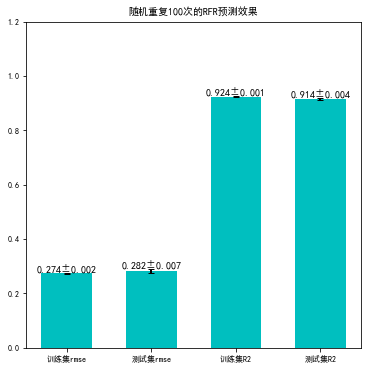

In [450]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'RFR',label,'saving')

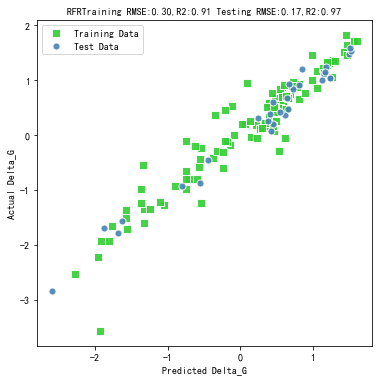

In [451]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'RFR',label,'saving')

In [49]:
best_rfr = best_regr

In [50]:
dump(best_rfr, "Models\\rfr_"+label+".joblib")    

['D:\\Code\\师妹\\zjnpaper_II\\图5\\Models\\rfr_20210516_1750.joblib']

In [452]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
rfr_predicted_result = [mean_rmse_r2,std_err]
rfr_predicted_result = pd.DataFrame(rfr_predicted_result)
rfr_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
rfr_predicted_result.index = ["Mean", "std"]
rfr_predicted_result.to_csv("Excels\\"+"RFR_"+label+".csv",sep=',')

In [52]:
end_time_rfr = datetime.datetime.now()
delta_rfr = end_time_rfr - end_time_krr
print(end_time_rfr)
print(delta_rfr)

2021-05-17 03:21:32.829851
0:53:08.813216


# XGBR

In [53]:
def generateXgbrParamGrid(low1,high1,num1,low2,high2,num2,low3,high3,num3,rating):      # 
    param_grid = {
        'n_estimators':np.arange(int(low1),int(high1),int(num1)),
        'max_depth':np.arange(int(low2),int(high2),int(num2)),
        'min_child_weight':np.arange(int(low3),int(high3),int(num3)),
        'learning_rate':[rating]
    }
    return param_grid

In [54]:
param = generateXgbrParamGrid(300,1100,100,3,11,1,1,4,1,0.1)
param

{'n_estimators': array([ 300,  400,  500,  600,  700,  800,  900, 1000]),
 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
 'min_child_weight': array([1, 2, 3]),
 'learning_rate': [0.1]}

In [55]:
search = generateSearch('xgbr','grid_search',param,-1,10)
search

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [56]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)

In [57]:
max_score

0.9999993794472313

In [58]:
best_regr

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [462]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,xgbr_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.965
RMSE_train: 0.191
r2_test:   0.974
RMSE_test: 0.150
--------------------------
---------round: 2---------
r2_train:   0.969
RMSE_train: 0.164
r2_test:   0.960
RMSE_test: 0.248
--------------------------
---------round: 3---------
r2_train:   0.966
RMSE_train: 0.180
r2_test:   0.966
RMSE_test: 0.199
--------------------------
---------round: 4---------
r2_train:   0.964
RMSE_train: 0.198
r2_test:   0.980
RMSE_test: 0.109
--------------------------
---------round: 5---------
r2_train:   0.973
RMSE_train: 0.172
r2_test:   0.921
RMSE_test: 0.224
--------------------------
---------round: 6---------
r2_train:   0.979
RMSE_train: 0.142
r2_test:   0.919
RMSE_test: 0.297
--------------------------
---------round: 7---------
r2_train:   0.964
RMSE_train: 0.189
r2_test:   0.974
RMSE_test: 0.161
--------------------------
---------round: 8---------
r2_train:   0.960
RMSE_train: 0.201
r2_test:   0.992
RMSE_test: 0.090
--------------------------
--------

r2_test:   0.936
RMSE_test: 0.227
--------------------------
---------round: 95---------
r2_train:   0.964
RMSE_train: 0.193
r2_test:   0.977
RMSE_test: 0.141
--------------------------
---------round: 96---------
r2_train:   0.978
RMSE_train: 0.144
r2_test:   0.920
RMSE_test: 0.293
--------------------------
---------round: 97---------
r2_train:   0.962
RMSE_train: 0.182
r2_test:   0.975
RMSE_test: 0.191
--------------------------
---------round: 98---------
r2_train:   0.960
RMSE_train: 0.202
r2_test:   0.993
RMSE_test: 0.078
--------------------------
---------round: 99---------
r2_train:   0.959
RMSE_train: 0.198
r2_test:   0.990
RMSE_test: 0.107
--------------------------
---------round: 100---------
r2_train:   0.965
RMSE_train: 0.188
r2_test:   0.972
RMSE_test: 0.168
--------------------------


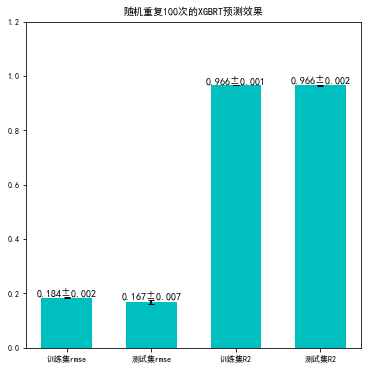

In [463]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'XGBR',label,'saving')

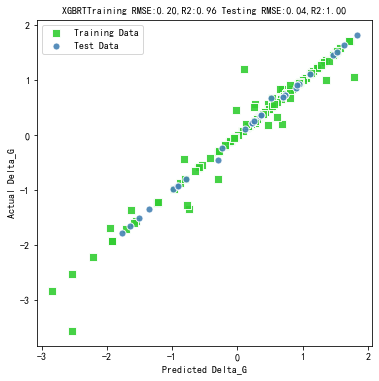

In [464]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'XGBR',label,'saving')

In [62]:
best_xgbr = best_regr

In [63]:
dump(best_xgbr, "Models\\xgbr_"+label+".joblib")    # 存储至硬盘

['D:\\Code\\师妹\\zjnpaper_II\\图5\\Models\\xgbrt_20210516_1750.joblib']

In [466]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
xgbr_predicted_result = [mean_rmse_r2,std_err]
xgbr_predicted_result = pd.DataFrame(xgbr_predicted_result)
xgbr_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
xgbr_predicted_result.index = ["Mean", "std"]
xgbr_predicted_result.to_csv("Excels\\"+"XGBR_"+label+".csv",sep=',')

In [65]:
end_time_xgbr = datetime.datetime.now()
delta_xgbr = end_time_xgbr - end_time_rfr
print(end_time_xgbr)
print(delta_xgbr)

2021-05-17 05:32:51.123571
2:11:18.293720


# LASSO

In [66]:
def generateLassoParamGrid(way,low,high,num,base,norm,max_iter):      
    if way=='logspace':
        param_grid = {
            'alpha':np.logspace(low,high,num,base=base),
            'normalize':norm,
            'max_iter':[int(max_iter)]
        }
        return param_grid
    
    elif way=='linspace':
        param_grid = {
            'alpha':np.linspace(low,high,num),
            'normalize':norm,
            'max_iter':[int(max_iter)]
        }
        return param_grid

In [67]:
param = generateLassoParamGrid('logspace',-4,4,100,10,[True],1000)     
param

{'alpha': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
        2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
        4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
        9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
        1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
        4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
        8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
        1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
        3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
        8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
        1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
        3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
        7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
        1.59228279e+00, 1.91791026e+00, 2.31012970e+00,

In [68]:
search = generateSearch('lasso','grid_search',param,-1,10)     
search

GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.8480...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                         'max_iter': [1000], 'normalize': [True]},
             scoring='r2')

In [69]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)                      

D:\Ana\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2554886323063652, tolerance: 0.01199619421891142
  model = cd_fast.enet_coordinate_descent(
D:\Ana\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.315087338408655, tolerance: 0.011672211508100295
  model = cd_fast.enet_coordinate_descent(
D:\Ana\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05244789111361747, tolerance: 0.012664602233718852
  model = cd_fast.enet_coordinate_descent(
D:\Ana\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the

In [70]:
max_score

0.9363034933723247

In [71]:
best_regr

Lasso(alpha=0.0001, normalize=True)

In [468]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,lasso_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.858
RMSE_train: 0.364
r2_test:   0.870
RMSE_test: 0.408
--------------------------
---------round: 2---------
r2_train:   0.852
RMSE_train: 0.393
r2_test:   0.907
RMSE_test: 0.276
--------------------------
---------round: 3---------
r2_train:   0.854
RMSE_train: 0.385
r2_test:   0.892
RMSE_test: 0.321
--------------------------
---------round: 4---------
r2_train:   0.864
RMSE_train: 0.382
r2_test:   0.842
RMSE_test: 0.333
--------------------------
---------round: 5---------
r2_train:   0.865
RMSE_train: 0.386
r2_test:   0.819
RMSE_test: 0.315
--------------------------
---------round: 6---------
r2_train:   0.856
RMSE_train: 0.379
r2_test:   0.880
RMSE_test: 0.347
--------------------------
---------round: 7---------
r2_train:   0.887
RMSE_train: 0.328
r2_test:   0.778
RMSE_test: 0.515
--------------------------
---------round: 8---------
r2_train:   0.854
RMSE_train: 0.381
r2_test:   0.885
RMSE_test: 0.339
--------------------------
--------

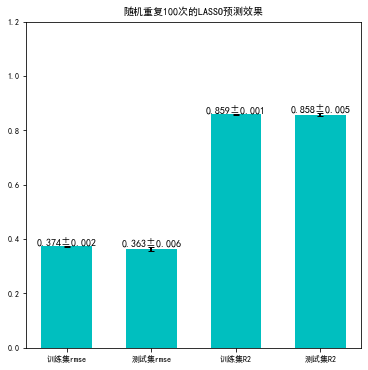

In [469]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'LASSO',label,'saving')

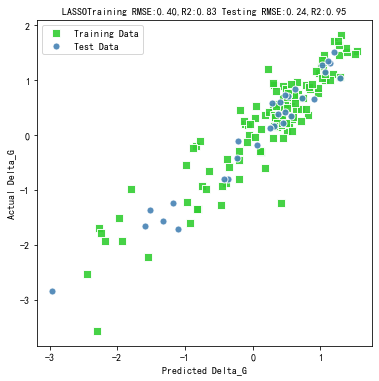

In [470]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'LASSO',label,'saving')

In [75]:
best_lasso = best_regr

In [76]:
dump(best_lasso, "Models\\lasso_"+label+".joblib")    

['D:\\Code\\师妹\\zjnpaper_II\\图5\\Models\\lasso_20210516_1750.joblib']

In [471]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
lasso_predicted_result = [mean_rmse_r2,std_err]
lasso_predicted_result = pd.DataFrame(lasso_predicted_result)
lasso_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
lasso_predicted_result.index = ["Mean", "std"]
lasso_predicted_result.to_csv("Excels\\"+"LASSO_"+label+".csv",sep=',')

In [78]:
end_time_lasso = datetime.datetime.now()
delta_lasso = end_time_lasso - end_time_xgbr
print(end_time_lasso)
print(delta_lasso)

2021-05-17 05:33:09.850461
0:00:18.726890


# keras ANNs 

In [616]:
def generateAnnsParamGrid(low1,high1,num1,low2,high2,num2):      
        param_grid = {
            'batch_size':np.arange(int(low1),int(high1),int(num1)),
            'epochs' :np.arange(int(low2),int(high2),int(num2)),
            'optimizer' : ['adam','sgd']
        }
        return param_grid

In [617]:
param = generateAnnsParamGrid(10,50,5,100,700,100)  
param

{'batch_size': array([10, 15, 20, 25, 30, 35, 40, 45]),
 'epochs': array([100, 200, 300, 400, 500, 600]),
 'optimizer': ['adam', 'sgd']}

In [618]:
search = generateSearch('anns','grid_search',param,-1,10)     
search

GridSearchCV(cv=10,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000023C100548B0>,
             n_jobs=-1,
             param_grid={'batch_size': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'epochs': array([100, 200, 300, 400, 500, 600]),
                         'optimizer': ['adam', 'sgd']},
             scoring='r2')

In [619]:
max_score,best_regr = optHyperparameter(x_data,y_data,test_size,n,search)  

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 25766.2812 - mean_absolute_error: 144.8790
Epoch 2/500
4/4 [==============================] - 0s 997us/step - loss: 10330.3838 - mean_absolute_error: 90.0031
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 6093.9966 - mean_absolute_error: 72.1429
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 3317.3604 - mean_absolute_error: 50.7389
Epoch 5/500
4/4 [==============================] - 0s 997us/step - loss: 1844.8097 - mean_absolute_error: 36.7267
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 1345.9490 - mean_absolute_error: 30.7578
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 975.0070 - mean_absolute_error: 26.1968
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 828.2059 - mean_absolute_error: 25.7293
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 639.0330 - mean_absolute_err

4/4 [==============================] - 0s 1ms/step - loss: 5.4373 - mean_absolute_error: 1.8132
Epoch 149/500
4/4 [==============================] - 0s 1ms/step - loss: 4.5597 - mean_absolute_error: 1.6236
Epoch 150/500
4/4 [==============================] - 0s 997us/step - loss: 5.4186 - mean_absolute_error: 1.8115
Epoch 151/500
4/4 [==============================] - 0s 997us/step - loss: 6.0184 - mean_absolute_error: 1.9035
Epoch 152/500
4/4 [==============================] - 0s 997us/step - loss: 4.6452 - mean_absolute_error: 1.6855
Epoch 153/500
4/4 [==============================] - 0s 997us/step - loss: 4.0139 - mean_absolute_error: 1.5640
Epoch 154/500
4/4 [==============================] - 0s 997us/step - loss: 5.0693 - mean_absolute_error: 1.7258
Epoch 155/500
4/4 [==============================] - 0s 1ms/step - loss: 5.2900 - mean_absolute_error: 1.8344
Epoch 156/500
4/4 [==============================] - 0s 1ms/step - loss: 5.6891 - mean_absolute_error: 1.8222
Epoch 157/500


Epoch 222/500
4/4 [==============================] - 0s 1ms/step - loss: 6.5515 - mean_absolute_error: 2.1538
Epoch 223/500
4/4 [==============================] - 0s 1ms/step - loss: 5.6334 - mean_absolute_error: 1.8467
Epoch 224/500
4/4 [==============================] - 0s 1ms/step - loss: 8.8783 - mean_absolute_error: 2.5007
Epoch 225/500
4/4 [==============================] - 0s 1ms/step - loss: 4.8141 - mean_absolute_error: 1.8019
Epoch 226/500
4/4 [==============================] - 0s 1ms/step - loss: 3.1171 - mean_absolute_error: 1.3282
Epoch 227/500
4/4 [==============================] - 0s 1ms/step - loss: 3.9850 - mean_absolute_error: 1.5819
Epoch 228/500
4/4 [==============================] - 0s 1ms/step - loss: 5.4486 - mean_absolute_error: 1.9128
Epoch 229/500
4/4 [==============================] - 0s 1ms/step - loss: 3.8069 - mean_absolute_error: 1.5139
Epoch 230/500
4/4 [==============================] - 0s 1ms/step - loss: 6.9601 - mean_absolute_error: 2.1551
Epoch 231/

Epoch 296/500
4/4 [==============================] - 0s 998us/step - loss: 16.0770 - mean_absolute_error: 3.6336
Epoch 297/500
4/4 [==============================] - 0s 997us/step - loss: 13.9968 - mean_absolute_error: 3.2418
Epoch 298/500
4/4 [==============================] - 0s 997us/step - loss: 11.5650 - mean_absolute_error: 2.8525
Epoch 299/500
4/4 [==============================] - 0s 1ms/step - loss: 30.6526 - mean_absolute_error: 4.7870
Epoch 300/500
4/4 [==============================] - 0s 997us/step - loss: 31.1268 - mean_absolute_error: 4.8692
Epoch 301/500
4/4 [==============================] - 0s 1ms/step - loss: 11.7409 - mean_absolute_error: 2.8020
Epoch 302/500
4/4 [==============================] - 0s 1ms/step - loss: 12.4135 - mean_absolute_error: 3.0653
Epoch 303/500
4/4 [==============================] - 0s 1ms/step - loss: 17.8628 - mean_absolute_error: 3.7036
Epoch 304/500
4/4 [==============================] - 0s 997us/step - loss: 23.2518 - mean_absolute_error

4/4 [==============================] - 0s 2ms/step - loss: 309.5693 - mean_absolute_error: 16.8638
Epoch 443/500
4/4 [==============================] - 0s 3ms/step - loss: 145.7206 - mean_absolute_error: 10.3147
Epoch 444/500
4/4 [==============================] - 0s 3ms/step - loss: 199.1881 - mean_absolute_error: 12.1582
Epoch 445/500
4/4 [==============================] - 0s 997us/step - loss: 124.8419 - mean_absolute_error: 9.6676
Epoch 446/500
4/4 [==============================] - 0s 1ms/step - loss: 78.4730 - mean_absolute_error: 7.2648
Epoch 447/500
4/4 [==============================] - 0s 1ms/step - loss: 34.1313 - mean_absolute_error: 4.6182
Epoch 448/500
4/4 [==============================] - 0s 1ms/step - loss: 49.4776 - mean_absolute_error: 5.8530
Epoch 449/500
4/4 [==============================] - 0s 1ms/step - loss: 78.5479 - mean_absolute_error: 7.8728
Epoch 450/500
4/4 [==============================] - 0s 997us/step - loss: 89.5685 - mean_absolute_error: 8.2547
Epoc

4/4 [==============================] - 0s 997us/step - loss: 20.1282 - mean_absolute_error: 3.6997
Epoch 90/600
4/4 [==============================] - 0s 997us/step - loss: 22.9956 - mean_absolute_error: 3.9958
Epoch 91/600
4/4 [==============================] - 0s 1ms/step - loss: 21.6685 - mean_absolute_error: 3.9288
Epoch 92/600
4/4 [==============================] - 0s 998us/step - loss: 19.1431 - mean_absolute_error: 3.5453
Epoch 93/600
4/4 [==============================] - 0s 1ms/step - loss: 19.5855 - mean_absolute_error: 3.6092
Epoch 94/600
4/4 [==============================] - 0s 1ms/step - loss: 19.9751 - mean_absolute_error: 3.5309
Epoch 95/600
4/4 [==============================] - 0s 1ms/step - loss: 21.7282 - mean_absolute_error: 3.8103
Epoch 96/600
4/4 [==============================] - 0s 1ms/step - loss: 18.0418 - mean_absolute_error: 3.5077
Epoch 97/600
4/4 [==============================] - 0s 1ms/step - loss: 22.6490 - mean_absolute_error: 3.7924
Epoch 98/600
4/4 

4/4 [==============================] - 0s 1ms/step - loss: 7.5065 - mean_absolute_error: 2.0624
Epoch 164/600
4/4 [==============================] - 0s 1ms/step - loss: 9.5098 - mean_absolute_error: 2.4407
Epoch 165/600
4/4 [==============================] - 0s 1ms/step - loss: 12.4024 - mean_absolute_error: 2.8457
Epoch 166/600
4/4 [==============================] - 0s 1ms/step - loss: 10.1883 - mean_absolute_error: 2.5185
Epoch 167/600
4/4 [==============================] - 0s 1ms/step - loss: 9.2127 - mean_absolute_error: 2.3899
Epoch 168/600
4/4 [==============================] - 0s 997us/step - loss: 10.8626 - mean_absolute_error: 2.5900
Epoch 169/600
4/4 [==============================] - 0s 1ms/step - loss: 10.3661 - mean_absolute_error: 2.5874
Epoch 170/600
4/4 [==============================] - 0s 1ms/step - loss: 8.7442 - mean_absolute_error: 2.2150
Epoch 171/600
4/4 [==============================] - 0s 1ms/step - loss: 6.7962 - mean_absolute_error: 2.0038
Epoch 172/600
4/4 

4/4 [==============================] - 0s 1ms/step - loss: 6.9864 - mean_absolute_error: 2.2002
Epoch 310/600
4/4 [==============================] - 0s 1ms/step - loss: 8.4369 - mean_absolute_error: 2.4287
Epoch 311/600
4/4 [==============================] - 0s 1ms/step - loss: 9.5941 - mean_absolute_error: 2.6238
Epoch 312/600
4/4 [==============================] - 0s 1ms/step - loss: 6.1590 - mean_absolute_error: 2.0126
Epoch 313/600
4/4 [==============================] - 0s 1ms/step - loss: 10.0427 - mean_absolute_error: 2.7212
Epoch 314/600
4/4 [==============================] - 0s 1ms/step - loss: 9.4075 - mean_absolute_error: 2.5446
Epoch 315/600
4/4 [==============================] - 0s 2ms/step - loss: 16.1649 - mean_absolute_error: 3.5178
Epoch 316/600
4/4 [==============================] - 0s 1ms/step - loss: 15.5620 - mean_absolute_error: 3.1147
Epoch 317/600
4/4 [==============================] - 0s 1ms/step - loss: 19.2087 - mean_absolute_error: 3.7092
Epoch 318/600
4/4 [=

4/4 [==============================] - 0s 2ms/step - loss: 139.4209 - mean_absolute_error: 11.1514
Epoch 457/600
4/4 [==============================] - 0s 2ms/step - loss: 88.4148 - mean_absolute_error: 8.1263
Epoch 458/600
4/4 [==============================] - 0s 2ms/step - loss: 79.5817 - mean_absolute_error: 7.6402
Epoch 459/600
4/4 [==============================] - 0s 1ms/step - loss: 142.9841 - mean_absolute_error: 10.2566
Epoch 460/600
4/4 [==============================] - 0s 2ms/step - loss: 183.4293 - mean_absolute_error: 12.5675
Epoch 461/600
4/4 [==============================] - 0s 2ms/step - loss: 179.0687 - mean_absolute_error: 12.2129
Epoch 462/600
4/4 [==============================] - 0s 1ms/step - loss: 165.5350 - mean_absolute_error: 11.1113
Epoch 463/600
4/4 [==============================] - 0s 1ms/step - loss: 115.0278 - mean_absolute_error: 9.3463
Epoch 464/600
4/4 [==============================] - 0s 2ms/step - loss: 86.3185 - mean_absolute_error: 7.9000
Epoc

12/12 [==============================] - 0s 831us/step - loss: 4305.2744 - mean_absolute_error: 55.4093
Epoch 3/600
12/12 [==============================] - 0s 914us/step - loss: 1213.5490 - mean_absolute_error: 28.5603
Epoch 4/600
12/12 [==============================] - 0s 914us/step - loss: 272.0707 - mean_absolute_error: 13.2083
Epoch 5/600
12/12 [==============================] - 0s 831us/step - loss: 124.1024 - mean_absolute_error: 9.0005
Epoch 6/600
12/12 [==============================] - 0s 831us/step - loss: 207.0008 - mean_absolute_error: 11.9875
Epoch 7/600
12/12 [==============================] - 0s 914us/step - loss: 141.0538 - mean_absolute_error: 9.1986
Epoch 8/600
12/12 [==============================] - 0s 914us/step - loss: 58.2129 - mean_absolute_error: 5.8579
Epoch 9/600
12/12 [==============================] - 0s 831us/step - loss: 47.9101 - mean_absolute_error: 5.4051
Epoch 10/600
12/12 [==============================] - 0s 831us/step - loss: 42.4102 - mean_absol

12/12 [==============================] - 0s 914us/step - loss: 9.0620 - mean_absolute_error: 2.3982
Epoch 145/600
12/12 [==============================] - 0s 831us/step - loss: 33.8703 - mean_absolute_error: 4.8037
Epoch 146/600
12/12 [==============================] - 0s 914us/step - loss: 26.8018 - mean_absolute_error: 4.4784
Epoch 147/600
12/12 [==============================] - 0s 831us/step - loss: 17.3836 - mean_absolute_error: 3.1544
Epoch 148/600
12/12 [==============================] - 0s 831us/step - loss: 16.5486 - mean_absolute_error: 3.2119
Epoch 149/600
12/12 [==============================] - 0s 831us/step - loss: 6.0415 - mean_absolute_error: 2.0382
Epoch 150/600
12/12 [==============================] - 0s 831us/step - loss: 28.9132 - mean_absolute_error: 4.4950
Epoch 151/600
12/12 [==============================] - 0s 831us/step - loss: 63.0802 - mean_absolute_error: 6.7242
Epoch 152/600
12/12 [==============================] - 0s 831us/step - loss: 31.8228 - mean_abso

12/12 [==============================] - 0s 831us/step - loss: 1.3218 - mean_absolute_error: 0.9074
Epoch 286/600
12/12 [==============================] - 0s 914us/step - loss: 4.1338 - mean_absolute_error: 1.6601
Epoch 287/600
12/12 [==============================] - 0s 748us/step - loss: 7.1355 - mean_absolute_error: 2.2743
Epoch 288/600
12/12 [==============================] - 0s 748us/step - loss: 8.2371 - mean_absolute_error: 2.3489
Epoch 289/600
12/12 [==============================] - 0s 831us/step - loss: 7.2902 - mean_absolute_error: 2.2919
Epoch 290/600
12/12 [==============================] - 0s 831us/step - loss: 10.0286 - mean_absolute_error: 2.6911
Epoch 291/600
12/12 [==============================] - 0s 831us/step - loss: 9.7617 - mean_absolute_error: 2.6192
Epoch 292/600
12/12 [==============================] - 0s 831us/step - loss: 3.0181 - mean_absolute_error: 1.2883
Epoch 293/600
12/12 [==============================] - 0s 748us/step - loss: 2.0405 - mean_absolute_e

12/12 [==============================] - 0s 914us/step - loss: 8.9446 - mean_absolute_error: 2.4729
Epoch 428/600
12/12 [==============================] - 0s 914us/step - loss: 8.7520 - mean_absolute_error: 2.2958
Epoch 429/600
12/12 [==============================] - 0s 831us/step - loss: 24.2250 - mean_absolute_error: 4.1973
Epoch 430/600
12/12 [==============================] - 0s 831us/step - loss: 19.6526 - mean_absolute_error: 3.7320
Epoch 431/600
12/12 [==============================] - 0s 831us/step - loss: 12.2186 - mean_absolute_error: 2.8771
Epoch 432/600
12/12 [==============================] - 0s 831us/step - loss: 51.8075 - mean_absolute_error: 6.2263
Epoch 433/600
12/12 [==============================] - 0s 831us/step - loss: 13.3507 - mean_absolute_error: 2.8063
Epoch 434/600
12/12 [==============================] - 0s 831us/step - loss: 12.1443 - mean_absolute_error: 2.8941
Epoch 435/600
12/12 [==============================] - 0s 831us/step - loss: 15.2772 - mean_abso

12/12 [==============================] - 0s 831us/step - loss: 19.8918 - mean_absolute_error: 3.8028
Epoch 570/600
12/12 [==============================] - 0s 914us/step - loss: 29.9298 - mean_absolute_error: 4.6934
Epoch 571/600
12/12 [==============================] - 0s 831us/step - loss: 34.4435 - mean_absolute_error: 4.9989
Epoch 572/600
12/12 [==============================] - 0s 831us/step - loss: 23.6647 - mean_absolute_error: 4.0354
Epoch 573/600
12/12 [==============================] - 0s 831us/step - loss: 24.3604 - mean_absolute_error: 4.3159
Epoch 574/600
12/12 [==============================] - 0s 831us/step - loss: 8.4944 - mean_absolute_error: 2.4214
Epoch 575/600
12/12 [==============================] - 0s 831us/step - loss: 10.2059 - mean_absolute_error: 2.7820
Epoch 576/600
12/12 [==============================] - 0s 831us/step - loss: 15.2028 - mean_absolute_error: 3.4436
Epoch 577/600
12/12 [==============================] - 0s 831us/step - loss: 39.1503 - mean_abs

D:\Ana\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/500
12/12 [==============================] - 0s 997us/step - loss: 13340.7646 - mean_absolute_error: 95.8392
Epoch 2/500
12/12 [==============================] - 0s 1ms/step - loss: 4579.2197 - mean_absolute_error: 54.8517
Epoch 3/500
12/12 [==============================] - 0s 997us/step - loss: 1889.3527 - mean_absolute_error: 38.1515
Epoch 4/500
12/12 [==============================] - 0s 1ms/step - loss: 615.6337 - mean_absolute_error: 20.0115
Epoch 5/500
12/12 [==============================] - 0s 1ms/step - loss: 279.9499 - mean_absolute_error: 13.6637
Epoch 6/500
12/12 [==============================] - 0s 1ms/step - loss: 316.9590 - mean_absolute_error: 13.9939
Epoch 7/500
12/12 [==============================] - 0s 997us/step - loss: 287.7410 - mean_absolute_error: 13.8670
Epoch 8/500
12/12 [==============================] - 0s 1ms/step - loss: 153.7472 - mean_absolute_error: 10.2029
Epoch 9/500
12/12 [==============================] - 0s 1ms/step - loss: 120.9504 - me

12/12 [==============================] - 0s 1ms/step - loss: 39.2162 - mean_absolute_error: 5.3653
Epoch 144/500
12/12 [==============================] - 0s 997us/step - loss: 18.1083 - mean_absolute_error: 3.4607
Epoch 145/500
12/12 [==============================] - 0s 997us/step - loss: 24.7338 - mean_absolute_error: 4.1409
Epoch 146/500
12/12 [==============================] - 0s 997us/step - loss: 25.4478 - mean_absolute_error: 4.2796
Epoch 147/500
12/12 [==============================] - 0s 997us/step - loss: 9.6430 - mean_absolute_error: 2.5316
Epoch 148/500
12/12 [==============================] - 0s 997us/step - loss: 6.9428 - mean_absolute_error: 2.1089
Epoch 149/500
12/12 [==============================] - 0s 1ms/step - loss: 13.1350 - mean_absolute_error: 3.0081
Epoch 150/500
12/12 [==============================] - 0s 997us/step - loss: 5.5561 - mean_absolute_error: 1.8098
Epoch 151/500
12/12 [==============================] - 0s 997us/step - loss: 7.9916 - mean_absolute_e

12/12 [==============================] - 0s 997us/step - loss: 275.7690 - mean_absolute_error: 14.5721
Epoch 285/500
12/12 [==============================] - 0s 1ms/step - loss: 366.8768 - mean_absolute_error: 16.7255
Epoch 286/500
12/12 [==============================] - 0s 1ms/step - loss: 742.7924 - mean_absolute_error: 22.7496
Epoch 287/500
12/12 [==============================] - 0s 997us/step - loss: 1316.4155 - mean_absolute_error: 31.8611
Epoch 288/500
12/12 [==============================] - 0s 997us/step - loss: 1703.1267 - mean_absolute_error: 35.3537
Epoch 289/500
12/12 [==============================] - 0s 914us/step - loss: 433.4753 - mean_absolute_error: 17.5801
Epoch 290/500
12/12 [==============================] - 0s 997us/step - loss: 227.8948 - mean_absolute_error: 12.9149
Epoch 291/500
12/12 [==============================] - 0s 1ms/step - loss: 117.3891 - mean_absolute_error: 8.9776
Epoch 292/500
12/12 [==============================] - 0s 914us/step - loss: 49.504

12/12 [==============================] - 0s 1ms/step - loss: 36.8843 - mean_absolute_error: 5.3130
Epoch 428/500
12/12 [==============================] - 0s 997us/step - loss: 30.8698 - mean_absolute_error: 4.6293
Epoch 429/500
12/12 [==============================] - 0s 997us/step - loss: 14.1385 - mean_absolute_error: 3.0422
Epoch 430/500
12/12 [==============================] - 0s 914us/step - loss: 8.2981 - mean_absolute_error: 2.3724
Epoch 431/500
12/12 [==============================] - 0s 914us/step - loss: 5.8823 - mean_absolute_error: 2.0210
Epoch 432/500
12/12 [==============================] - 0s 831us/step - loss: 2.8930 - mean_absolute_error: 1.3672
Epoch 433/500
12/12 [==============================] - 0s 997us/step - loss: 2.9550 - mean_absolute_error: 1.3801
Epoch 434/500
12/12 [==============================] - ETA: 0s - loss: 1.1956 - mean_absolute_error: 0.701 - 0s 914us/step - loss: 1.3243 - mean_absolute_error: 0.8983
Epoch 435/500
12/12 [==========================

D:\Ana\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/600
12/12 [==============================] - 0s 830us/step - loss: 27793.0176 - mean_absolute_error: 128.8722
Epoch 2/600
12/12 [==============================] - 0s 914us/step - loss: 5882.7202 - mean_absolute_error: 60.4126
Epoch 3/600
12/12 [==============================] - 0s 997us/step - loss: 2500.7461 - mean_absolute_error: 42.2049
Epoch 4/600
12/12 [==============================] - 0s 917us/step - loss: 762.3387 - mean_absolute_error: 23.5495
Epoch 5/600
12/12 [==============================] - 0s 914us/step - loss: 363.4931 - mean_absolute_error: 15.1264
Epoch 6/600
12/12 [==============================] - 0s 832us/step - loss: 275.8146 - mean_absolute_error: 12.8404
Epoch 7/600
12/12 [==============================] - 0s 831us/step - loss: 199.9597 - mean_absolute_error: 11.3131
Epoch 8/600
12/12 [==============================] - 0s 914us/step - loss: 149.1765 - mean_absolute_error: 9.8082
Epoch 9/600
12/12 [==============================] - 0s 831us/step - loss: 9

12/12 [==============================] - 0s 831us/step - loss: 48.7244 - mean_absolute_error: 5.8284
Epoch 144/600
12/12 [==============================] - 0s 914us/step - loss: 34.0618 - mean_absolute_error: 4.7767
Epoch 145/600
12/12 [==============================] - 0s 831us/step - loss: 16.5733 - mean_absolute_error: 3.2581
Epoch 146/600
12/12 [==============================] - 0s 831us/step - loss: 32.9294 - mean_absolute_error: 4.5254
Epoch 147/600
12/12 [==============================] - 0s 831us/step - loss: 43.6101 - mean_absolute_error: 5.3439
Epoch 148/600
12/12 [==============================] - 0s 831us/step - loss: 79.9911 - mean_absolute_error: 7.6797
Epoch 149/600
12/12 [==============================] - 0s 831us/step - loss: 41.7777 - mean_absolute_error: 5.1673
Epoch 150/600
12/12 [==============================] - 0s 831us/step - loss: 30.9191 - mean_absolute_error: 4.5293
Epoch 151/600
12/12 [==============================] - 0s 914us/step - loss: 133.2301 - mean_a

Epoch 285/600
12/12 [==============================] - 0s 914us/step - loss: 8.7184 - mean_absolute_error: 2.4017
Epoch 286/600
12/12 [==============================] - 0s 831us/step - loss: 17.9308 - mean_absolute_error: 3.4284
Epoch 287/600
12/12 [==============================] - 0s 914us/step - loss: 2.7701 - mean_absolute_error: 1.3216
Epoch 288/600
12/12 [==============================] - 0s 831us/step - loss: 6.6750 - mean_absolute_error: 2.0937
Epoch 289/600
12/12 [==============================] - 0s 831us/step - loss: 9.7678 - mean_absolute_error: 2.5342
Epoch 290/600
12/12 [==============================] - 0s 831us/step - loss: 3.0526 - mean_absolute_error: 1.3585
Epoch 291/600
12/12 [==============================] - 0s 831us/step - loss: 5.0968 - mean_absolute_error: 1.7885
Epoch 292/600
12/12 [==============================] - 0s 831us/step - loss: 8.7596 - mean_absolute_error: 2.5584
Epoch 293/600
12/12 [==============================] - 0s 831us/step - loss: 4.0547 - m

12/12 [==============================] - 0s 831us/step - loss: 332.4296 - mean_absolute_error: 16.0967
Epoch 428/600
12/12 [==============================] - 0s 914us/step - loss: 72.2652 - mean_absolute_error: 6.4963
Epoch 429/600
12/12 [==============================] - 0s 748us/step - loss: 23.2215 - mean_absolute_error: 3.9383
Epoch 430/600
12/12 [==============================] - 0s 748us/step - loss: 7.1469 - mean_absolute_error: 2.1055
Epoch 431/600
12/12 [==============================] - 0s 831us/step - loss: 10.8249 - mean_absolute_error: 2.5983
Epoch 432/600
12/12 [==============================] - 0s 748us/step - loss: 6.2609 - mean_absolute_error: 2.0207
Epoch 433/600
12/12 [==============================] - 0s 831us/step - loss: 7.1667 - mean_absolute_error: 2.2869
Epoch 434/600
12/12 [==============================] - 0s 831us/step - loss: 8.6647 - mean_absolute_error: 2.3704
Epoch 435/600
12/12 [==============================] - 0s 831us/step - loss: 7.4259 - mean_absol

12/12 [==============================] - 0s 831us/step - loss: 9.2549 - mean_absolute_error: 2.6684
Epoch 569/600
12/12 [==============================] - 0s 831us/step - loss: 4.0144 - mean_absolute_error: 1.6507
Epoch 570/600
12/12 [==============================] - 0s 831us/step - loss: 3.9184 - mean_absolute_error: 1.5157
Epoch 571/600
12/12 [==============================] - 0s 831us/step - loss: 3.3245 - mean_absolute_error: 1.4977
Epoch 572/600
12/12 [==============================] - 0s 914us/step - loss: 1.5048 - mean_absolute_error: 0.9726
Epoch 573/600
12/12 [==============================] - 0s 831us/step - loss: 1.0829 - mean_absolute_error: 0.8027
Epoch 574/600
12/12 [==============================] - 0s 831us/step - loss: 6.7354 - mean_absolute_error: 2.2591
Epoch 575/600
12/12 [==============================] - 0s 914us/step - loss: 2.9824 - mean_absolute_error: 1.4415
Epoch 576/600
12/12 [==============================] - 0s 831us/step - loss: 7.1431 - mean_absolute_er

12/12 [==============================] - 0s 914us/step - loss: 100.7067 - mean_absolute_error: 7.9163
Epoch 111/400
12/12 [==============================] - 0s 914us/step - loss: 43.9373 - mean_absolute_error: 5.2516
Epoch 112/400
12/12 [==============================] - 0s 914us/step - loss: 62.0848 - mean_absolute_error: 6.5212
Epoch 113/400
12/12 [==============================] - 0s 831us/step - loss: 66.0214 - mean_absolute_error: 7.0153
Epoch 114/400
12/12 [==============================] - ETA: 0s - loss: 137.4889 - mean_absolute_error: 10.54 - 0s 831us/step - loss: 120.8495 - mean_absolute_error: 9.3936
Epoch 115/400
12/12 [==============================] - 0s 914us/step - loss: 55.3327 - mean_absolute_error: 6.0172
Epoch 116/400
12/12 [==============================] - 0s 914us/step - loss: 50.6210 - mean_absolute_error: 6.0451
Epoch 117/400
12/12 [==============================] - 0s 831us/step - loss: 17.8570 - mean_absolute_error: 3.3936
Epoch 118/400
12/12 [===============

12/12 [==============================] - 0s 874us/step - loss: 15.2547 - mean_absolute_error: 3.2878
Epoch 249/400
12/12 [==============================] - 0s 831us/step - loss: 5.0176 - mean_absolute_error: 1.8140
Epoch 250/400
12/12 [==============================] - 0s 831us/step - loss: 10.3580 - mean_absolute_error: 2.6465
Epoch 251/400
12/12 [==============================] - 0s 914us/step - loss: 46.1460 - mean_absolute_error: 5.6736
Epoch 252/400
12/12 [==============================] - 0s 914us/step - loss: 64.6555 - mean_absolute_error: 7.1848
Epoch 253/400
12/12 [==============================] - 0s 914us/step - loss: 142.8985 - mean_absolute_error: 10.2766
Epoch 254/400
12/12 [==============================] - 0s 831us/step - loss: 497.2498 - mean_absolute_error: 18.6569
Epoch 255/400
12/12 [==============================] - 0s 831us/step - loss: 323.8792 - mean_absolute_error: 14.9514
Epoch 256/400
12/12 [==============================] - 0s 831us/step - loss: 136.2968 - m

12/12 [==============================] - 0s 999us/step - loss: 59.7695 - mean_absolute_error: 5.9814
Epoch 14/600
12/12 [==============================] - 0s 918us/step - loss: 56.8788 - mean_absolute_error: 5.9515
Epoch 15/600
12/12 [==============================] - 0s 999us/step - loss: 57.9094 - mean_absolute_error: 6.2477
Epoch 16/600
12/12 [==============================] - 0s 833us/step - loss: 57.6242 - mean_absolute_error: 5.8532
Epoch 17/600
12/12 [==============================] - 0s 916us/step - loss: 52.8359 - mean_absolute_error: 5.5727
Epoch 18/600
12/12 [==============================] - 0s 833us/step - loss: 60.8067 - mean_absolute_error: 6.2981
Epoch 19/600
12/12 [==============================] - 0s 916us/step - loss: 49.8132 - mean_absolute_error: 5.7104
Epoch 20/600
12/12 [==============================] - 0s 917us/step - loss: 90.4727 - mean_absolute_error: 7.8114
Epoch 21/600
12/12 [==============================] - 0s 916us/step - loss: 60.5623 - mean_absolute_e

12/12 [==============================] - 0s 833us/step - loss: 12.6865 - mean_absolute_error: 2.8097
Epoch 156/600
12/12 [==============================] - 0s 916us/step - loss: 23.3825 - mean_absolute_error: 3.9567
Epoch 157/600
12/12 [==============================] - 0s 916us/step - loss: 32.0967 - mean_absolute_error: 4.5668
Epoch 158/600
12/12 [==============================] - 0s 917us/step - loss: 28.7842 - mean_absolute_error: 4.5928
Epoch 159/600
12/12 [==============================] - 0s 915us/step - loss: 25.1073 - mean_absolute_error: 3.9208
Epoch 160/600
12/12 [==============================] - 0s 917us/step - loss: 35.7412 - mean_absolute_error: 5.1568
Epoch 161/600
12/12 [==============================] - 0s 876us/step - loss: 33.7856 - mean_absolute_error: 4.7735
Epoch 162/600
12/12 [==============================] - 0s 916us/step - loss: 21.5740 - mean_absolute_error: 3.7934
Epoch 163/600
12/12 [==============================] - 0s 916us/step - loss: 62.5437 - mean_ab

12/12 [==============================] - 0s 833us/step - loss: 17.2655 - mean_absolute_error: 3.5231
Epoch 297/600
12/12 [==============================] - 0s 833us/step - loss: 23.5222 - mean_absolute_error: 3.9671
Epoch 298/600
12/12 [==============================] - 0s 916us/step - loss: 40.0162 - mean_absolute_error: 5.2712
Epoch 299/600
12/12 [==============================] - 0s 999us/step - loss: 36.6292 - mean_absolute_error: 5.2289
Epoch 300/600
12/12 [==============================] - 0s 1ms/step - loss: 44.9280 - mean_absolute_error: 5.8488
Epoch 301/600
12/12 [==============================] - 0s 1ms/step - loss: 31.2985 - mean_absolute_error: 4.3694
Epoch 302/600
12/12 [==============================] - 0s 1ms/step - loss: 4.7115 - mean_absolute_error: 1.7614
Epoch 303/600
12/12 [==============================] - 0s 1ms/step - loss: 7.6657 - mean_absolute_error: 2.3053
Epoch 304/600
12/12 [==============================] - 0s 834us/step - loss: 3.8034 - mean_absolute_erro

12/12 [==============================] - 0s 833us/step - loss: 2.4135 - mean_absolute_error: 1.2721
Epoch 439/600
12/12 [==============================] - 0s 1000us/step - loss: 1.8884 - mean_absolute_error: 1.1116
Epoch 440/600
12/12 [==============================] - 0s 834us/step - loss: 2.2073 - mean_absolute_error: 1.2376
Epoch 441/600
12/12 [==============================] - 0s 833us/step - loss: 3.9927 - mean_absolute_error: 1.6929
Epoch 442/600
12/12 [==============================] - 0s 833us/step - loss: 2.2581 - mean_absolute_error: 1.2081
Epoch 443/600
12/12 [==============================] - 0s 833us/step - loss: 7.7010 - mean_absolute_error: 2.2654
Epoch 444/600
12/12 [==============================] - 0s 916us/step - loss: 6.3904 - mean_absolute_error: 2.1168
Epoch 445/600
12/12 [==============================] - 0s 833us/step - loss: 3.3640 - mean_absolute_error: 1.5051
Epoch 446/600
12/12 [==============================] - 0s 917us/step - loss: 4.1712 - mean_absolute_e

12/12 [==============================] - 0s 997us/step - loss: 61.3438 - mean_absolute_error: 6.6130
Epoch 106/300
12/12 [==============================] - 0s 914us/step - loss: 94.7097 - mean_absolute_error: 7.9833
Epoch 107/300
12/12 [==============================] - 0s 914us/step - loss: 162.9207 - mean_absolute_error: 10.8679
Epoch 108/300
12/12 [==============================] - 0s 914us/step - loss: 60.2943 - mean_absolute_error: 6.1303
Epoch 109/300
12/12 [==============================] - 0s 914us/step - loss: 14.2691 - mean_absolute_error: 3.0464
Epoch 110/300
12/12 [==============================] - 0s 914us/step - loss: 15.7404 - mean_absolute_error: 3.2650
Epoch 111/300
12/12 [==============================] - 0s 831us/step - loss: 101.1409 - mean_absolute_error: 8.0339
Epoch 112/300
12/12 [==============================] - 0s 914us/step - loss: 89.8790 - mean_absolute_error: 7.8837
Epoch 113/300
12/12 [==============================] - 0s 831us/step - loss: 153.9824 - mea

12/12 [==============================] - 0s 1000us/step - loss: 4.8098 - mean_absolute_error: 1.7593
Epoch 247/300
12/12 [==============================] - 0s 1ms/step - loss: 12.5075 - mean_absolute_error: 3.0104
Epoch 248/300
12/12 [==============================] - 0s 919us/step - loss: 12.8031 - mean_absolute_error: 2.9085
Epoch 249/300
12/12 [==============================] - 0s 1000us/step - loss: 6.8392 - mean_absolute_error: 2.1519
Epoch 250/300
12/12 [==============================] - 0s 997us/step - loss: 4.2008 - mean_absolute_error: 1.5998
Epoch 251/300
12/12 [==============================] - 0s 1000us/step - loss: 5.6228 - mean_absolute_error: 1.9964
Epoch 252/300
12/12 [==============================] - 0s 999us/step - loss: 4.7856 - mean_absolute_error: 1.7726
Epoch 253/300
12/12 [==============================] - 0s 1ms/step - loss: 14.3703 - mean_absolute_error: 3.0981
Epoch 254/300
12/12 [==============================] - 0s 1000us/step - loss: 8.7361 - mean_absolute

D:\Ana\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/600
12/12 [==============================] - 0s 1ms/step - loss: 27406.5117 - mean_absolute_error: 138.2106
Epoch 2/600
12/12 [==============================] - 0s 914us/step - loss: 8383.6855 - mean_absolute_error: 78.7249
Epoch 3/600
12/12 [==============================] - 0s 997us/step - loss: 4268.2051 - mean_absolute_error: 55.9354
Epoch 4/600
12/12 [==============================] - 0s 997us/step - loss: 1321.8995 - mean_absolute_error: 30.1554
Epoch 5/600
12/12 [==============================] - 0s 914us/step - loss: 548.4103 - mean_absolute_error: 19.1453
Epoch 6/600
12/12 [==============================] - 0s 914us/step - loss: 288.3789 - mean_absolute_error: 13.2161
Epoch 7/600
12/12 [==============================] - 0s 914us/step - loss: 253.0515 - mean_absolute_error: 12.8921
Epoch 8/600
12/12 [==============================] - 0s 831us/step - loss: 163.0969 - mean_absolute_error: 10.1562
Epoch 9/600
12/12 [==============================] - 0s 914us/step - loss: 1

12/12 [==============================] - 0s 1ms/step - loss: 32.4934 - mean_absolute_error: 4.8887
Epoch 145/600
12/12 [==============================] - 0s 1ms/step - loss: 33.2359 - mean_absolute_error: 4.9803
Epoch 146/600
12/12 [==============================] - 0s 1ms/step - loss: 24.9617 - mean_absolute_error: 4.0729
Epoch 147/600
12/12 [==============================] - 0s 1ms/step - loss: 7.2412 - mean_absolute_error: 2.1417
Epoch 148/600
12/12 [==============================] - 0s 997us/step - loss: 9.9262 - mean_absolute_error: 2.5936
Epoch 149/600
12/12 [==============================] - 0s 1ms/step - loss: 41.2125 - mean_absolute_error: 5.4233
Epoch 150/600
12/12 [==============================] - 0s 1ms/step - loss: 8.4271 - mean_absolute_error: 2.2611
Epoch 151/600
12/12 [==============================] - 0s 997us/step - loss: 8.8238 - mean_absolute_error: 2.4994
Epoch 152/600
12/12 [==============================] - 0s 997us/step - loss: 29.6277 - mean_absolute_error: 4.

12/12 [==============================] - 0s 1ms/step - loss: 7.1859 - mean_absolute_error: 2.2272
Epoch 289/600
12/12 [==============================] - 0s 1ms/step - loss: 17.1935 - mean_absolute_error: 3.4016
Epoch 290/600
12/12 [==============================] - 0s 1ms/step - loss: 58.3732 - mean_absolute_error: 6.3435
Epoch 291/600
12/12 [==============================] - 0s 1ms/step - loss: 33.7984 - mean_absolute_error: 4.7333
Epoch 292/600
12/12 [==============================] - 0s 1ms/step - loss: 65.3059 - mean_absolute_error: 6.8961
Epoch 293/600
12/12 [==============================] - 0s 1ms/step - loss: 58.7565 - mean_absolute_error: 6.3782
Epoch 294/600
12/12 [==============================] - 0s 1ms/step - loss: 47.8513 - mean_absolute_error: 5.8959
Epoch 295/600
12/12 [==============================] - 0s 999us/step - loss: 10.0086 - mean_absolute_error: 2.4512
Epoch 296/600
12/12 [==============================] - 0s 1ms/step - loss: 18.5792 - mean_absolute_error: 3.3

12/12 [==============================] - 0s 1ms/step - loss: 85.1200 - mean_absolute_error: 8.3013
Epoch 360/600
12/12 [==============================] - 0s 1ms/step - loss: 31.1538 - mean_absolute_error: 4.7272
Epoch 361/600
12/12 [==============================] - 0s 1ms/step - loss: 87.6634 - mean_absolute_error: 8.0886
Epoch 362/600
12/12 [==============================] - 0s 1ms/step - loss: 120.5795 - mean_absolute_error: 9.4403
Epoch 363/600
12/12 [==============================] - 0s 1ms/step - loss: 103.1650 - mean_absolute_error: 8.4496
Epoch 364/600
12/12 [==============================] - 0s 1ms/step - loss: 101.3924 - mean_absolute_error: 8.7863
Epoch 365/600
12/12 [==============================] - 0s 1ms/step - loss: 43.3207 - mean_absolute_error: 5.1250
Epoch 366/600
12/12 [==============================] - 0s 1ms/step - loss: 16.0212 - mean_absolute_error: 3.2304
Epoch 367/600
12/12 [==============================] - 0s 1ms/step - loss: 77.8559 - mean_absolute_error: 7

12/12 [==============================] - 0s 1ms/step - loss: 1.1813 - mean_absolute_error: 0.8492
Epoch 504/600
12/12 [==============================] - 0s 1ms/step - loss: 3.1567 - mean_absolute_error: 1.4977
Epoch 505/600
12/12 [==============================] - 0s 1ms/step - loss: 1.6925 - mean_absolute_error: 1.0759
Epoch 506/600
12/12 [==============================] - 0s 1ms/step - loss: 1.3154 - mean_absolute_error: 0.9402
Epoch 507/600
12/12 [==============================] - 0s 1ms/step - loss: 1.0223 - mean_absolute_error: 0.8666
Epoch 508/600
12/12 [==============================] - 0s 1ms/step - loss: 1.7203 - mean_absolute_error: 1.0826
Epoch 509/600
12/12 [==============================] - 0s 999us/step - loss: 7.1278 - mean_absolute_error: 2.2973
Epoch 510/600
12/12 [==============================] - 0s 1ms/step - loss: 5.9518 - mean_absolute_error: 2.1090
Epoch 511/600
12/12 [==============================] - 0s 1ms/step - loss: 3.4878 - mean_absolute_error: 1.5126
Epoc

3/3 [==============================] - 0s 2ms/step - loss: 14.2849 - mean_absolute_error: 2.8999
Epoch 49/400
3/3 [==============================] - 0s 2ms/step - loss: 15.7354 - mean_absolute_error: 3.1112
Epoch 50/400
3/3 [==============================] - 0s 2ms/step - loss: 14.5639 - mean_absolute_error: 2.8807
Epoch 51/400
3/3 [==============================] - 0s 2ms/step - loss: 15.1845 - mean_absolute_error: 3.0144
Epoch 52/400
3/3 [==============================] - 0s 1ms/step - loss: 15.1615 - mean_absolute_error: 2.9265
Epoch 53/400
3/3 [==============================] - 0s 2ms/step - loss: 14.7385 - mean_absolute_error: 2.9516
Epoch 54/400
3/3 [==============================] - 0s 2ms/step - loss: 13.5408 - mean_absolute_error: 2.7898
Epoch 55/400
3/3 [==============================] - 0s 2ms/step - loss: 13.9385 - mean_absolute_error: 2.8935
Epoch 56/400
3/3 [==============================] - 0s 2ms/step - loss: 13.2187 - mean_absolute_error: 2.8070
Epoch 57/400
3/3 [=====

Epoch 196/400
3/3 [==============================] - 0s 2ms/step - loss: 5.3098 - mean_absolute_error: 1.8151
Epoch 197/400
3/3 [==============================] - 0s 2ms/step - loss: 5.9681 - mean_absolute_error: 1.9589
Epoch 198/400
3/3 [==============================] - 0s 2ms/step - loss: 5.8173 - mean_absolute_error: 1.9387
Epoch 199/400
3/3 [==============================] - 0s 2ms/step - loss: 5.8864 - mean_absolute_error: 1.9538
Epoch 200/400
3/3 [==============================] - 0s 1ms/step - loss: 8.1892 - mean_absolute_error: 2.2716
Epoch 201/400
3/3 [==============================] - 0s 2ms/step - loss: 6.1205 - mean_absolute_error: 2.0129
Epoch 202/400
3/3 [==============================] - 0s 2ms/step - loss: 4.9439 - mean_absolute_error: 1.7832
Epoch 203/400
3/3 [==============================] - 0s 2ms/step - loss: 7.0272 - mean_absolute_error: 2.1630
Epoch 204/400
3/3 [==============================] - 0s 1ms/step - loss: 5.9855 - mean_absolute_error: 1.9311
Epoch 205/

Epoch 270/400
3/3 [==============================] - 0s 1ms/step - loss: 6.4012 - mean_absolute_error: 2.1284
Epoch 271/400
3/3 [==============================] - 0s 1ms/step - loss: 6.5040 - mean_absolute_error: 2.1251
Epoch 272/400
3/3 [==============================] - 0s 1ms/step - loss: 4.9723 - mean_absolute_error: 1.6829
Epoch 273/400
3/3 [==============================] - 0s 1ms/step - loss: 8.3728 - mean_absolute_error: 2.4448
Epoch 274/400
3/3 [==============================] - 0s 2ms/step - loss: 5.5705 - mean_absolute_error: 1.9294
Epoch 275/400
3/3 [==============================] - 0s 2ms/step - loss: 3.9212 - mean_absolute_error: 1.6132
Epoch 276/400
3/3 [==============================] - 0s 2ms/step - loss: 4.1737 - mean_absolute_error: 1.6532
Epoch 277/400
3/3 [==============================] - 0s 2ms/step - loss: 5.8414 - mean_absolute_error: 2.0143
Epoch 278/400
3/3 [==============================] - 0s 2ms/step - loss: 7.2313 - mean_absolute_error: 2.2946
Epoch 279/

In [620]:
max_score

0.46446468605744307

In [621]:
best_regr

In [622]:
bs = best_regr.sk_params['batch_size']
es = best_regr.sk_params['epochs']
op = best_regr.sk_params['optimizer']
print('最佳batch_size: %s ，最佳epochs: %s，最佳optimizer: %s'%(bs,es,op))

最佳batch_size: 10 ，最佳epochs: 600，最佳optimizer: sgd


In [623]:
r2_train,rmse_train,r2_test,rmse_test,best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,anns_worst_mae= \
fitRegression(x_data,y_data,test_size,N,best_regr)

---------round: 1---------
r2_train:   0.386
RMSE_train: 0.785
r2_test:   0.247
RMSE_test: 0.864
--------------------------
---------round: 2---------
r2_train:   0.341
RMSE_train: 0.829
r2_test:   0.453
RMSE_test: 0.680
--------------------------
---------round: 3---------
r2_train:   0.242
RMSE_train: 0.753
r2_test:   0.476
RMSE_test: 0.970
--------------------------
---------round: 4---------
r2_train:   0.315
RMSE_train: 0.817
r2_test:   0.495
RMSE_test: 0.736
--------------------------
---------round: 5---------
r2_train:   0.334
RMSE_train: 0.833
r2_test:   0.484
RMSE_test: 0.657
--------------------------
---------round: 6---------
r2_train:   0.364
RMSE_train: 0.827
r2_test:   0.325
RMSE_test: 0.688
--------------------------
---------round: 7---------
r2_train:   0.330
RMSE_train: 0.836
r2_test:   0.484
RMSE_test: 0.645
--------------------------
---------round: 8---------
r2_train:   0.403
RMSE_train: 0.798
r2_test:   0.107
RMSE_test: 0.813
--------------------------
--------

r2_train:   0.399
RMSE_train: 0.823
r2_test:   -0.020
RMSE_test: 0.707
--------------------------
---------round: 68---------
r2_train:   0.406
RMSE_train: 0.772
r2_test:   0.164
RMSE_test: 0.907
--------------------------
---------round: 69---------
r2_train:   0.385
RMSE_train: 0.818
r2_test:   -0.070
RMSE_test: 0.729
--------------------------
---------round: 70---------
r2_train:   0.391
RMSE_train: 0.801
r2_test:   0.191
RMSE_test: 0.802
--------------------------
---------round: 71---------
r2_train:   0.322
RMSE_train: 0.823
r2_test:   0.494
RMSE_test: 0.707
--------------------------
---------round: 72---------
r2_train:   0.366
RMSE_train: 0.783
r2_test:   0.338
RMSE_test: 0.868
--------------------------
---------round: 73---------
r2_train:   0.445
RMSE_train: 0.770
r2_test:   -0.138
RMSE_test: 0.913
--------------------------
---------round: 74---------
r2_train:   0.276
RMSE_train: 0.813
r2_test:   0.581
RMSE_test: 0.751
--------------------------
---------round: 75-------

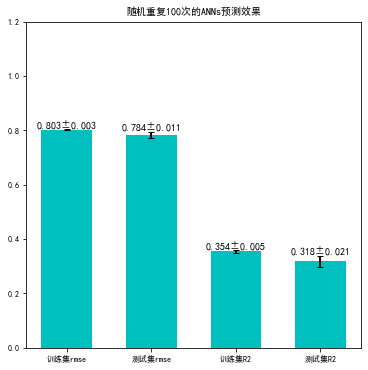

In [631]:
plotBar(r2_train,rmse_train,r2_test,rmse_test,N,'ANNs',label,'saving')

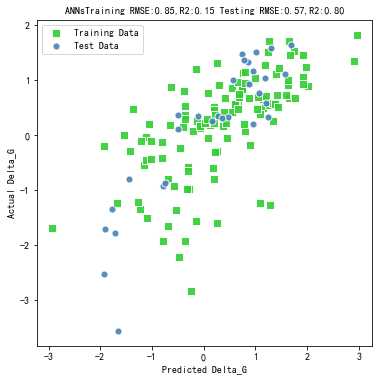

In [632]:
plotScatter(best_r2,best_rmse,y_train_best,y_train_predict_best,y_test_best,y_test_predict_best,'ANNs',label,'saving')

In [629]:
best_regr.model.save("Models\\anns_"+label+".h5")

In [630]:
rmse_r2 = [rmse_train, rmse_test, r2_train, r2_test]
mean_rmse_r2 = np.mean(rmse_r2,1) 
std_err = np.std(rmse_r2,axis=1,ddof=1)/np.sqrt(N) 
anns_predicted_result = [mean_rmse_r2,std_err]
anns_predicted_result = pd.DataFrame(anns_predicted_result)
anns_predicted_result.columns = ["Training rmse", "Testing rmse", "Training R2", "Testing R2"]
anns_predicted_result.index = ["Mean", "std"]
anns_predicted_result.to_csv("Time\\"+"ANNS_"+label+".csv",sep=',')

In [514]:
end_time_anns = datetime.datetime.now()
delta_anns = end_time_anns - end_time_lasso
print(end_time_anns)
print(delta_anns)

2021-05-17 23:39:39.898163
18:06:30.047702


# The ending of time

In [93]:
time_comp = [delta_svr,delta_krr,delta_rfr,delta_xgbr,delta_lasso,delta_anns]
time_comp = pd.DataFrame(time_comp)
time_comp.columns=['time cost']
time_comp.index = ['SVR','KRR','RFR','XGBR','LASSO','ANNs']
time_comp.to_csv("Time\\"+"Time_"+label+".csv",sep=',')

# The worst MAE in a trial for best model

In [94]:
worst_mae = [svr_worst_mae,krr_worst_mae,rfr_worst_mae,xgbrt_worst_mae,lasso_worst_mae,anns_worst_mae] 
worst_mae = pd.DataFrame(worst_mae)
worst_mae.columns=['mae']
worst_mae.index = ['SVR','KRR','RFR','XGBR','LASSO','ANNs']
worst_mae.to_csv("Worst\\"+"worstMAE_"+label+".csv",sep=',')

# Delete global variable

In [95]:
del N,n,label,test_size